# Instalación de paqueterías

Vamos a enumerar primeramente todas las paqueterías que necesitaremos a lo largo de nuestro código. En cada uno de los pasos, iremos especificando en dónde hacemos utilidad de cada una de las librerías importadas. Si hay alguna paquetería que tu sistema no tenga instalada, encontraremos el error marcado al importar las librerías.

In [1]:
######################### Paqueterías necesarias para la revisión de las versiones de nuestros programas ##################
from platform import python_version
import pkg_resources
###########################################################################################################################

######################### Librerías necesarias para trabajar con PyTorch ##################################################
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary
import torch.optim as optim
###########################################################################################################################

####################### Librerías complementarias #########################################################################
import time
import read_data
from collections import OrderedDict 
import matplotlib.pyplot as plt

# Implementación de nuestro código de Device

Vamos a importar las funciones que usamos en el Notebook Set-Up Device, para poder trabajar, ya sea tanto en CPU, como en GPU, sin ningún problema.

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [3]:
device=get_device()
device

device(type='cpu')

In [4]:
def to_device(data, device):
    if isinstance(data, (list,tuple)): #nos regresa True o False, si el data es del tipo especificado en la segunda entrada
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# comienzo del trabajo formal de la red neuronal

In [6]:
to_gen_xs = open("H-SymFunc.smf")
txt = to_gen_xs.read()
print(txt)
to_gen_xs.close()

ï»¿# 10/22/2019 water different molecules
# Parameters to generate the G2 and G3 symmetry functions described by J Behler, JCP 134, 074106 (2011).

# CentralAtom is the i-atom
CentralAtom H

# Number of symmetry functions 42
Type G2 
# j-atom eta Rs      Rc
H    0.005  0.000  12.000
O    0.005  0.000  12.000
H    0.008  0.000  12.000
O    0.008  0.000  12.000
H    0.013  0.000  12.000
O    0.013  0.000  12.000
H    0.020  0.000  12.000
O    0.020  0.000  12.000
H    0.027  0.000  12.000
O    0.027  0.000  12.000
H    0.041  0.000  12.000
O    0.041  0.000  12.000
H    0.059  0.000  12.000
O    0.059  0.000  12.000
H    0.087  0.000  12.000
O    0.087  0.000  12.000
H    0.151  0.000  12.000
O    0.151  0.000  12.000
H    0.215  0.000  12.000
O    0.215  0.000  12.000
Type G4
# j-k-atoms    eta     lambda   zeta    Rc
 H  H    0.000  -1.000   1.000  12.000
 H  O    0.000  -1.000   1.000  12.000
 O  O    0.000  -1.000   1.000  12.000
 H  H    0.000   1.000   1.000  12.000
 H  O    0.000 

In [7]:
import torch
import torch.nn as nn

In [8]:
#```python
# Ejemplo 3
# This cell loads the data for the bo222-100k system

system_name = 'bo222-100k-200k'             # Nombre del sistema
data_path = "./data/bo222-100k-200k-function.data"            # Dirección de los datos para hacer el entrenamiento
number_frames = 4000                        # Número de muestras
number_atoms_per_frame = 222                # Número de átomos en cada muestra
number_atoms_per_type = [98, 94, 30]     # Número de átomos de cada tipo
number_atom_types = 3                        # Número de tipos de átomo           
number_features_per_type = [78, 78, 78]     # Número de rasgos para cada tipo de átomo 
#```

In [9]:
import time
import read_data

start_reading_data = time.time()

data, energy_scale = read_data.read_data(data_path,number_frames,number_atoms_per_frame,number_atoms_per_type,number_features_per_type)

end_reading_data = time.time()
print("reading and shifting and scaling data done. time: {0}s".format(end_reading_data-start_reading_data))

maximum output: -64.90398406982422
minimum output: -64.90711975097656
maximum output: 1.8023798069533037
minimum output: -0.4356204971488347
reading and shifting and scaling data done. time: 241.70641326904297s


In [10]:
print("data es una {} de tamaño {}.".format(type(data), len(data)))
print("Each element of the list is a frame object ( {} ) ".format(data[0]))
print("that contains the features and the target of the corresponding xyz frame.")

data es una <class 'list'> de tamaño 4000.
Each element of the list is a frame object ( <frame.Frame object at 0x0000025A583639B0> ) 
that contains the features and the target of the corresponding xyz frame.


# Anotación 1

Hasta esta parte del código, no se ha hecho cambio alguno con el framework de Keras. A partir de aquí, comenzamos a dividir data en data x y data y, y después, volveremos a partir los datas correspondientes, en tensores de Pytorch

In [11]:
import numpy as np

data_x=[]
for i in range(number_atom_types):
    data_x.append(np.array([frame.get_input(i) for frame in data]))
    
data_y= np.array([frame.get_energy_of_frame_as_array() for frame in data])

In [12]:
print("data_x es una {} de tamaño {}.".format(type(data_x), len(data_x)), '\n')

for i in range(len(data_x)):
    print("Para el átomo tipo ", i+1, ", data_x[{}] es un {} de forma {}.".
          format(i, type(data_x[i]), data_x[i].shape))

data_x es una <class 'list'> de tamaño 3. 

Para el átomo tipo  1 , data_x[0] es un <class 'numpy.ndarray'> de forma (4000, 98, 78).
Para el átomo tipo  2 , data_x[1] es un <class 'numpy.ndarray'> de forma (4000, 94, 78).
Para el átomo tipo  3 , data_x[2] es un <class 'numpy.ndarray'> de forma (4000, 30, 78).


# Anotación 2

Hasta esta parte, lo que tenemos es lo siguiente:
- Tenemos un data_x, que es una lista de arreglos de numpy. Los arreglos de numpy se pueden convertir fácilmente a tensores de Pytorch, que es lo que haremos a continuación. Pero debemos partir la información en los diferentes átomos. Presentamos a continuación una figura que ilustra lo que tenemos en data_x, y lo que podemos hacer

<img src="./im_1_data_x.png" width=520 height=520 align = "center" >

Dato que la organización del data_x no nos permite definir un tensor global data_x, podemos trabajar con diccionarios ordenados OrderedDict, para poder manejar nuestros datos de manera adecuada

In [13]:
data_x_0_pt=torch.tensor(data_x[0])
data_x_1_pt=torch.tensor(data_x[1])
data_x_2_pt=torch.tensor(data_x[2])

data_x_0_pt=to_device(data_x_0_pt, device)
data_x_1_pt=to_device(data_x_1_pt, device)
data_x_2_pt=to_device(data_x_2_pt, device)

In [14]:
from collections import OrderedDict
data_x_pt=OrderedDict([
    (0, data_x_0_pt),
    (1, data_x_1_pt),
    (2, data_x_2_pt)
])

data_y_pt=torch.tensor(data_y)
data_y_pt=to_device(data_y_pt, device)

Así, vamos a poder entender cómo se manejan los datos de un framework a otro. En Keras, teníamos que poner el índice correspondiente, para conocer la información del atómo de tipo 0, 1 y 2. Por eso, hemos puesto las llaves de nuestro diccionario de esta manera

In [15]:
data_x_pt[0].shape

torch.Size([4000, 98, 78])

In [16]:
data_x_pt[1].shape

torch.Size([4000, 94, 78])

In [17]:
data_x_pt[2].shape

torch.Size([4000, 30, 78])

<img src="./im_2_data_pt.png" width=520 height=520 align = "center" >

Aquí tenemos una imagen representativa de lo que se buscó hacer con el diccionario. Ya podemos manejar con mayor facilidad los datos. Y cada elemento del diccionario, ya es un tensor de Pytorch

- Otra de las necesidades de tener que crear el diccionario de tensores, es que, a diferencia de Keras, no tenemos en Pytorch un layer de Input, que además tenga como variable desconocidas las dos primeras dimensiones del tensor, que es lo que hace `None` en Keras. Entonces, debemos conocer perfectamente las dimensiones de nuestros tensores, para poder alimentar a la red

- Finalmente, vamos a partir el problema en dos ciclos. La principal razón de hacer este procedimiento, es que para crear los batches, utilizaremos `torch.utils.data.DataLoader`, que tiene la restricción de que todos las muestras que tome, deben ser de las mismas dimensiones

<font size=6, color=blue>
    Histograma de un rasgo

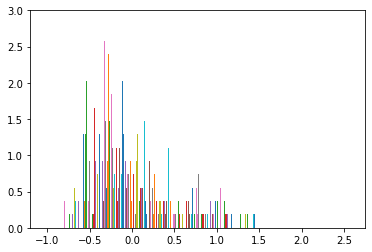

In [18]:
import matplotlib.pyplot as plt
tipo_de_atomo=0

rasgo=60

plt.ylim(0,3)
plt.hist(data_x_pt[tipo_de_atomo][:][:][rasgo].numpy(), bins='auto', density=True)
plt.show()

<font size=6, color=blue>
    Histograma de la energía total

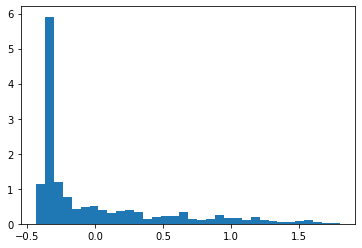

In [19]:
plt.hist(data_y_pt.numpy(), bins='auto', density=True)
plt.show()

<font size=6, color=blue>
    Construcción del modelo de aprendizaje

In [20]:
torch.manual_seed(10)

Vamos a contruir el modelo de aprendizaje, siguiendo como diagrama la siguiente imagen

<img src="./im_4_ciclos.png" width=520 height=520 align = "center" >

Tenemos entonces tres entradas, provenientes de cada tipo de átomo. Pasarán individualmente a un ciclo individual (color azul), el cual tiene un subciclo (verde). Y teniendo el entrenamiento de los tres ciclos indoividuales, los juntaremos finalmente en el ciclo final (color rosa)

# Propiedad de broadcasting de PyTorch

Vamos a definir la función especial de tangente hiperbólico 

Primero, vamos a definir dicga función de activación, como una función cualquiera de Python

In [21]:
def tanh_plus_x(x):
    layer=nn.Tanh()
    return 1.7159 * layer((2.0*x)/3.0) + 0.01*x

Veamos que sí trabaja nuestra función adecuadamente

In [22]:
prueba=torch.tensor([0.1488,0.7839])
prueba

tensor([0.1488, 0.7839])

In [23]:
tanh_plus_x(prueba)

tensor([0.1711, 0.8310])

- Si somos observadores, en realidad no hubo necesidad de definir un tensor constante, y luego aplicar una función de multiplicación especial, para hacer nuestra función. Lo que pasó es que PyTorch tiene una propiedad, llamada **broadcasting**, la cual sigue una serie de reglas para multiplicar tensores bajo el símbolo *. Por eso, no tuvimos que lidiar mucho para definir esta función.

Ahora sí, vamos a convertirla en una función de activación

In [24]:
class tanh_plus(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        return tanh_plus_x(input)

De nuevo, probemos que todo selió bien

In [25]:
otro=tanh_plus()

In [26]:
ya=torch.rand(3)
to_device(otro(ya),device)

tensor([0.5129, 0.5389, 0.3555])

Y vamos a comenzar con nuestro primer subciclo

In [27]:
class subciclo_layer(nn.Module):
    def __init__(self,x_i,layers, dropout):
        super().__init__()
        self.layers=layers
        self.x_i=x_i
        self.dropout=dropout
        for layer in self.layers[:-1]:
            self.lineal=nn.Linear(x_i.shape[-1],layer)
            torch.nn.init.uniform_(self.lineal.weight, a=0.0, b=1.0)
            torch.nn.init.zeros_(self.lineal.bias)
            self.tanh=tanh_plus()
            if dropout:
                self.dr=nn.Dropout(p=0.4)
    def forward(self,x):
        for layer in layers[:-1]:
            out=self.lineal(x)
            out=self.tanh(out)
            if dropout:
                self.dr(out)
        return out

Vamos a poner una prueba, para ver que nuestro modelo está funcionando

In [28]:
layers=[15,15,1]
dropout=True
x_pruebo=torch.rand(16,90,78)
submodel=subciclo_layer(x_pruebo,layers, dropout)
submodel=to_device(submodel, device) #vayamos acostumbrándonos a pasar todo lo que hagamos, al device de trabajo

In [29]:
submodel(x_pruebo).shape

torch.Size([16, 90, 15])

Vamos a realizar algunas aclaraciones, que nos parecen pertinentes para comprender esta manera de generar un modelo en Pytorch

- Primero, Pytorch también tiene su manera Secuencial de definir las capas que integrarán nuestro modelo; dicha forma de hacerlo es con `nn.Sequential(capas)` (NOTA: En Pytorch las capas (layers) se denominan módulos. Es importante recordarlo, porque puede ser que al consultar literatura, pueda existir confusión por simple definición.)

- Nosotros no utilizaremos esta manera de programar, pues el modo secuencial se usa para capas que no necesitan más que parámetros fijos para definir los módulos (capas); es decir, no nos permite realizar modificaciones o integrar funciones de activación, como lo requerimos para este caso concreto del Notebook 15. 

- Ahora, seamos observadores, y comparemos el código de este subciclo, con el de la función de activación que definimos para la tangente hiperbólica. Hay un comando extra: `super().__init__()`. ¿Qué función cumple esta nueva línea de código? Nos permite declarar variables, que utilizaremos más adelante en la definición de nuestros layers como parámetros. Sin él, __init__ no puede leer estas variables dentro de los layers. 

- Como estamos utilizando clases de `torch.nn`, hay que recordar que siempre necesitamos declararlos, con sus respectivos parámetros si son necesarios, previo a pasarles el tensor a calcular el modelo. Es por ende, que utilizamos __init__ para declarar las capas con los parámetros necesarios, y en __forward__ ya realizamos el procedimiento de calcular el tensor que buscamos

# Modelo individual

El siguiente paso dentro de nuestro esquema de codificación de nuestro problema, es crear el ciclo individual, que deberemos aplicar a nuestros tipos de átomos, para después en un paso posterior, sumar el resultado de cada uno de los modelos individuales. Es aquí donde integraremos nuestro subciclo. recordando que **ya es una clase de nn**. Por lo tanto, no nos olvidemos de declararlo primero en __init__, y luego pasarle los datos necesarios a __forward__ para completar el cálculo

## My_Layer en Pytorch

Para poder programar este módulo (layer) en Pytorch, primero, vamos a entender qué es lo que hace la función, comenzando priemro analizando la sintaxis que viene en Keras

- Primero, lo que en Layer llama `call`, nosotros lo traducimos en Pytorch como `forward`. 

- Luego, vemos que aplica una suma. Como tenemos tres dimensiones, podemos especificar dos ejes, sobre los cuales se realizará la suma. Al seleccionar como ejes `axis=(1,2)`, lo que sucede es que vamos a sumar cada elemento de las rebanadas que componen nuestro tensor en tres dimensiones. Anexamos un dibujo ilustrativo de lo que hace `K.sum`

<img src="./im_3_ksum.png" width=920 height=920 align = "center" >

- Finalmente, como tenemos un tensor de dimensiones 1x3 en el caso del ejemplo de la figura, le aplicamos un reshape, para que quede de 3x1 

Teniendo entendido lo que realiza el código de My_Layer, vamos a traducirlo a PyTorch

In [30]:
class My_layer(nn.Module):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(My_layer, self).__init__(**kwargs)

    def forward(self, x):
        return torch.reshape(torch.sum(x, axis=(1,2)),(-1,self.output_dim))

Veamos que funcione adecuadamente My_layer

In [31]:
apli=My_layer(1)

In [32]:
prueb1=torch.rand(16,2,4)
to_device(apli(prueb1),device)

tensor([[2.1573],
        [3.5457],
        [2.2692],
        [4.3796],
        [4.1776],
        [4.7145],
        [2.5673],
        [3.5006],
        [2.2882],
        [4.4589],
        [2.3788],
        [4.7249],
        [6.3124],
        [3.5455],
        [5.0423],
        [5.0376]])

In [33]:
class ciclo_individual(nn.Module):
    def __init__(self,x_i,layers, dropout):
        super().__init__()
        self.layers=layers
        self.x_i=x_i
        self.dropout=dropout
        self.ML=My_layer(1)
        
        self.subciclo=subciclo_layer(x_i,layers,dropout)
        self.lineal=nn.Linear(layers[-2],layers[-1])
        torch.nn.init.uniform_(self.lineal.weight, a=0.0, b=1.0)
        torch.nn.init.zeros_(self.lineal.bias)
        
    def forward(self,x):
        out=self.subciclo(x)
        out=self.lineal(out)
        out=self.ML(out)
        return out

In [34]:
layers=[15,15,1]
dropout=True
x_prueba=torch.rand(16,90,78)
submodel=ciclo_individual(x_prueba,layers, dropout)

In [35]:
submodel(x_prueba)
submodel=to_device(submodel,device)
salida=submodel(x_prueba)
salida

tensor([[1253.6292],
        [1252.1151],
        [1253.4590],
        [1254.0170],
        [1255.8977],
        [1254.7489],
        [1252.4786],
        [1252.9811],
        [1254.1718],
        [1253.6630],
        [1255.4050],
        [1253.7975],
        [1255.2604],
        [1254.2384],
        [1254.1342],
        [1253.4880]], grad_fn=<ViewBackward>)

In [36]:
salida.device

device(type='cpu')

Vamos a crear una capa que no viene explícitamente en Pytorch, pero que en Keras lo agregamos con `from keras.layers.merge import Add`

In [37]:
class Merge_add(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, out1, out2, out3):
        zeros=torch.zeros(out1.shape)
        lista_ten=[out1,out2,out3]
        for out in lista_ten:
            zeros += out
        return zeros

Finalmente, crearemos el ciclo final para terminar nuestra arquitectura

In [38]:
class ciclo_final(nn.Module):
     def __init__(self, x_i, layers, dropout):
        super().__init__()
        self.indivi= ciclo_individual(x_i, layers, dropout)
        self.add=Merge_add()
     
     def forward(self, x1,x2,x3):
        out1=self.indivi(x1)
        out2=self.indivi(x2)
        out3=self.indivi(x3)
        out=self.add(out1,out2,out3)
        
        return out

In [39]:
layers=[15,15,1]
dropout=True
x1=torch.rand(16,90,78)
x2=torch.rand(16,80,78)
x3=torch.rand(16,80,78)

modelo=ciclo_final(x1,layers,dropout)
modelo=to_device(modelo, device)

In [40]:
modelo(x1,x2,x3).shape

torch.Size([16, 1])

In [41]:
modelo

ciclo_final(
  (indivi): ciclo_individual(
    (ML): My_layer()
    (subciclo): subciclo_layer(
      (lineal): Linear(in_features=78, out_features=15, bias=True)
      (tanh): tanh_plus()
      (dr): Dropout(p=0.4, inplace=False)
    )
    (lineal): Linear(in_features=15, out_features=1, bias=True)
  )
  (add): Merge_add()
)

In [42]:
from torchvision import models
from torchsummary import summary

batch_size=16
summary(modelo, [data_x_pt[0].shape,data_x_pt[1].shape,data_x_pt[2].shape])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [-1, 4000, 98, 15]           1,185
         tanh_plus-2         [-1, 4000, 98, 15]               0
           Dropout-3         [-1, 4000, 98, 15]               0
            Linear-4         [-1, 4000, 98, 15]           1,185
         tanh_plus-5         [-1, 4000, 98, 15]               0
           Dropout-6         [-1, 4000, 98, 15]               0
    subciclo_layer-7         [-1, 4000, 98, 15]               0
            Linear-8          [-1, 4000, 98, 1]              16
          My_layer-9                    [-1, 1]               0
 ciclo_individual-10                    [-1, 1]               0
           Linear-11         [-1, 4000, 94, 15]           1,185
        tanh_plus-12         [-1, 4000, 94, 15]               0
          Dropout-13         [-1, 4000, 94, 15]               0
           Linear-14         [-1, 4000,

# Creación de los Dataset para poder tener los Mini_batches

In [43]:
dataset_0_train=[]
dataset_0_val=[]
dataset_1_train=[]
dataset_1_val=[]
dataset_2_train=[]
dataset_2_val=[]

val_rate=0.1
val_integer=int((1-val_rate)*(data_x_pt[0].shape[0]))
val_integer
for i in range(data_x_pt[0].shape[0]):
    if i < val_integer:
        dataset_0_train.append((data_x_pt[0][i],data_y_pt[i]))
        dataset_1_train.append((data_x_pt[1][i],data_y_pt[i]))
        dataset_2_train.append((data_x_pt[2][i],data_y_pt[i]))
    else:
        dataset_0_val.append((data_x_pt[0][i],data_y_pt[i]))
        dataset_1_val.append((data_x_pt[1][i],data_y_pt[i]))
        dataset_2_val.append((data_x_pt[2][i],data_y_pt[i]))

In [44]:
train_loader_0=torch.utils.data.DataLoader(dataset_0_train, batch_size=16, shuffle=True)
train_loader_1=torch.utils.data.DataLoader(dataset_1_train, batch_size=16, shuffle=True)
train_loader_2=torch.utils.data.DataLoader(dataset_2_train, batch_size=16, shuffle=True)
val_loader_0=torch.utils.data.DataLoader(dataset_0_val, batch_size=16, shuffle=True)
val_loader_1=torch.utils.data.DataLoader(dataset_1_val, batch_size=16, shuffle=True)
val_loader_2=torch.utils.data.DataLoader(dataset_2_val, batch_size=16, shuffle=True)

Vamos a usar nuestro `DeviceDataLoader` en esta parte del código

In [45]:
train_loader_0=DeviceDataLoader(train_loader_0, device)
train_loader_1=DeviceDataLoader(train_loader_1, device)
train_loader_2=DeviceDataLoader(train_loader_2, device)

val_loader_0=DeviceDataLoader(val_loader_0, device)
val_loader_1=DeviceDataLoader(val_loader_1, device)
val_loader_2=DeviceDataLoader(val_loader_2, device)

La razón de haber hecho este paso, es que DataLoader no acepta tensores de diferentes tamaños. Por lo que tuvimos que crearlos nosotros mismos. Igualmente, recordemos que la desventaja que tenemos en PyTorch, es que debemos conocer las dimensiones, por lo que no pudimos usar `None` en nuestro modelo

In [46]:
modelo=ciclo_final(data_x_pt[0],layers, dropout)
modelo=to_device(modelo, device)

# Entrenamiento

In [47]:
import torch.optim as optim
def training_loop(num_epochs, modelo):
    criterion = nn. MSELoss()
    learning_rate = 0.005
    optimizer = optim.Adagrad(modelo.parameters(), lr=learning_rate,lr_decay=0, weight_decay=0, initial_accumulator_value=1.0, eps=1e-08)
    for i in range(1, num_epochs+1):
        running_loss=0
        for (x0, y0), (x1, y1),(x2, y2) in zip(train_loader_0, train_loader_1, train_loader_2):
            outputs=modelo(x1,x2,x3)
            loss = criterion(outputs.float(), y2.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print("Epoch: {}, Training loss: {}".format(i,running_loss))

                    
                    
        

## Nota

En el cálculo del gasto (loss), tuvimos que agregar `.float()` a ambos argumentos de la función, ya que de lo contrario, el programa marca un error, pues recibirá argumentos con distintos `dtype`

In [48]:
training_loop(100,modelo)

Epoch: 1, Training loss: 286828134.3125
Epoch: 2, Training loss: 174682611.5
Epoch: 3, Training loss: 124959381.40625
Epoch: 4, Training loss: 94005432.21875
Epoch: 5, Training loss: 72653878.34375
Epoch: 6, Training loss: 57062901.0
Epoch: 7, Training loss: 45303212.359375
Epoch: 8, Training loss: 36217947.59375
Epoch: 9, Training loss: 29103888.4921875
Epoch: 10, Training loss: 23453638.046875
Epoch: 11, Training loss: 18929713.53125
Epoch: 12, Training loss: 15288665.5703125
Epoch: 13, Training loss: 12354773.3984375
Epoch: 14, Training loss: 9974137.322265625
Epoch: 15, Training loss: 8067842.73046875
Epoch: 16, Training loss: 6527387.953125
Epoch: 17, Training loss: 5291092.3984375
Epoch: 18, Training loss: 4296340.36328125
Epoch: 19, Training loss: 3492490.734375
Epoch: 20, Training loss: 2848593.9697265625
Epoch: 21, Training loss: 2324789.1826171875
Epoch: 22, Training loss: 1896337.9809570312
Epoch: 23, Training loss: 1553429.2138671875
Epoch: 24, Training loss: 1273451.520507

In [49]:
def validate_loss(modelo, num_epochs):
    modelo.eval()
    criterion = nn. MSELoss()
    learning_rate = 0.005
    optimizer = optim.Adagrad(modelo.parameters(), lr=learning_rate,lr_decay=0, weight_decay=0, initial_accumulator_value=1.0, eps=1e-08)
    for i in range(1, num_epochs+1):
        running_loss=0
        for (x0, y0), (x1, y1),(x2, y2) in zip(val_loader_0, val_loader_1, val_loader_2):
            with torch.no_grad():
                outputs=modelo(x1,x2,x3)
                loss = criterion(outputs.float(), y0.float())
            
                optimizer.zero_grad()
                #loss.backward()
                optimizer.step()

                running_loss += loss.item()
        print("Epoch: {}, Training loss: {}".format(i,running_loss))
    

In [50]:
validate_loss(modelo,100)

Epoch: 1, Training loss: 6625.365493774414
Epoch: 2, Training loss: 6399.7132568359375
Epoch: 3, Training loss: 6578.537979125977
Epoch: 4, Training loss: 6548.339157104492
Epoch: 5, Training loss: 6398.20573425293
Epoch: 6, Training loss: 6450.496643066406
Epoch: 7, Training loss: 6526.926025390625
Epoch: 8, Training loss: 6446.53971862793
Epoch: 9, Training loss: 6443.266265869141
Epoch: 10, Training loss: 6467.658721923828
Epoch: 11, Training loss: 6430.116592407227
Epoch: 12, Training loss: 6382.395858764648
Epoch: 13, Training loss: 6332.777725219727
Epoch: 14, Training loss: 6419.305587768555
Epoch: 15, Training loss: 6530.495307922363
Epoch: 16, Training loss: 6435.654083251953
Epoch: 17, Training loss: 6584.871246337891
Epoch: 18, Training loss: 6381.272689819336
Epoch: 19, Training loss: 6469.285293579102
Epoch: 20, Training loss: 6332.043960571289
Epoch: 21, Training loss: 6484.612686157227
Epoch: 22, Training loss: 6488.5970458984375
Epoch: 23, Training loss: 6492.3021697998

In [51]:
def fit(modelo, num_epochs):
    print("Training Loss \n")
    training_loop(num_epochs,modelo)
    print("Validation Loss \n")
    validate_loss(modelo, num_epochs)
    

In [54]:
fit(modelo,1000)

Training Loss 

Epoch: 1, Training loss: 2085.6604595184326
Epoch: 2, Training loss: 1735.1494903564453
Epoch: 3, Training loss: 1659.1402189731598
Epoch: 4, Training loss: 1620.7659931182861
Epoch: 5, Training loss: 1581.4648325443268
Epoch: 6, Training loss: 1524.8351647853851
Epoch: 7, Training loss: 1494.042650461197
Epoch: 8, Training loss: 1478.6120176315308
Epoch: 9, Training loss: 1406.2101775407791
Epoch: 10, Training loss: 1402.3128443956375
Epoch: 11, Training loss: 1408.8534848690033
Epoch: 12, Training loss: 1379.9552167654037
Epoch: 13, Training loss: 1331.7767465114594
Epoch: 14, Training loss: 1329.9608577489853
Epoch: 15, Training loss: 1316.4384591579437
Epoch: 16, Training loss: 1283.6990307569504
Epoch: 17, Training loss: 1291.7091102600098
Epoch: 18, Training loss: 1253.7614606618881
Epoch: 19, Training loss: 1203.88631606102
Epoch: 20, Training loss: 1238.045284628868
Epoch: 21, Training loss: 1187.355516910553
Epoch: 22, Training loss: 1192.0408046245575
Epoch: 2

Epoch: 185, Training loss: 585.9747380614281
Epoch: 186, Training loss: 572.422801554203
Epoch: 187, Training loss: 587.05081397295
Epoch: 188, Training loss: 583.4391450881958
Epoch: 189, Training loss: 573.7479212284088
Epoch: 190, Training loss: 574.7949761748314
Epoch: 191, Training loss: 595.0482039451599
Epoch: 192, Training loss: 569.4979938268661
Epoch: 193, Training loss: 567.2333047389984
Epoch: 194, Training loss: 581.0212769508362
Epoch: 195, Training loss: 570.1785442829132
Epoch: 196, Training loss: 578.0650225877762
Epoch: 197, Training loss: 583.4060086011887
Epoch: 198, Training loss: 592.924457192421
Epoch: 199, Training loss: 572.122420668602
Epoch: 200, Training loss: 572.9657335877419
Epoch: 201, Training loss: 571.1164484024048
Epoch: 202, Training loss: 571.6555458903313
Epoch: 203, Training loss: 560.4100093841553
Epoch: 204, Training loss: 565.8136438727379
Epoch: 205, Training loss: 559.6275952458382
Epoch: 206, Training loss: 546.7476889491081
Epoch: 207, Tra

Epoch: 367, Training loss: 424.6317209005356
Epoch: 368, Training loss: 425.3783462047577
Epoch: 369, Training loss: 428.1928572654724
Epoch: 370, Training loss: 420.02260863780975
Epoch: 371, Training loss: 413.03854936361313
Epoch: 372, Training loss: 422.176310300827
Epoch: 373, Training loss: 413.2971932888031
Epoch: 374, Training loss: 411.63712245225906
Epoch: 375, Training loss: 426.622866332531
Epoch: 376, Training loss: 413.8206519186497
Epoch: 377, Training loss: 412.3495995402336
Epoch: 378, Training loss: 419.94186186790466
Epoch: 379, Training loss: 427.8388223052025
Epoch: 380, Training loss: 410.60394537448883
Epoch: 381, Training loss: 401.48171439766884
Epoch: 382, Training loss: 428.3970694541931
Epoch: 383, Training loss: 419.59363359212875
Epoch: 384, Training loss: 422.2445711493492
Epoch: 385, Training loss: 407.64861983060837
Epoch: 386, Training loss: 413.79597222805023
Epoch: 387, Training loss: 412.0414134860039
Epoch: 388, Training loss: 416.9840533733368
Epo

Epoch: 548, Training loss: 352.4235483109951
Epoch: 549, Training loss: 348.2594003677368
Epoch: 550, Training loss: 353.8304861187935
Epoch: 551, Training loss: 336.631771504879
Epoch: 552, Training loss: 342.9490233659744
Epoch: 553, Training loss: 339.87831476330757
Epoch: 554, Training loss: 352.73171949386597
Epoch: 555, Training loss: 344.6084548830986
Epoch: 556, Training loss: 332.4766064584255
Epoch: 557, Training loss: 352.70077097415924
Epoch: 558, Training loss: 347.7415928840637
Epoch: 559, Training loss: 339.59621888399124
Epoch: 560, Training loss: 348.4951182603836
Epoch: 561, Training loss: 352.81444746255875
Epoch: 562, Training loss: 342.164752304554
Epoch: 563, Training loss: 346.1823875308037
Epoch: 564, Training loss: 341.0061305165291
Epoch: 565, Training loss: 350.48450219631195
Epoch: 566, Training loss: 341.0992856025696
Epoch: 567, Training loss: 339.2708585858345
Epoch: 568, Training loss: 344.54090145230293
Epoch: 569, Training loss: 335.479729950428
Epoch:

Epoch: 729, Training loss: 305.69656881690025
Epoch: 730, Training loss: 298.46096831560135
Epoch: 731, Training loss: 298.50720858573914
Epoch: 732, Training loss: 297.8423972129822
Epoch: 733, Training loss: 301.57943230867386
Epoch: 734, Training loss: 303.3607243001461
Epoch: 735, Training loss: 292.070567548275
Epoch: 736, Training loss: 303.40859635174274
Epoch: 737, Training loss: 295.2474056184292
Epoch: 738, Training loss: 294.2418255805969
Epoch: 739, Training loss: 295.2913895249367
Epoch: 740, Training loss: 290.5724959373474
Epoch: 741, Training loss: 302.4266848266125
Epoch: 742, Training loss: 290.9289628267288
Epoch: 743, Training loss: 290.7173461318016
Epoch: 744, Training loss: 297.4541704505682
Epoch: 745, Training loss: 294.47249814867973
Epoch: 746, Training loss: 291.23484271764755
Epoch: 747, Training loss: 291.2275914847851
Epoch: 748, Training loss: 288.7187221646309
Epoch: 749, Training loss: 294.86404529213905
Epoch: 750, Training loss: 283.83623434603214
Ep

Epoch: 910, Training loss: 252.17701494693756
Epoch: 911, Training loss: 265.14052625000477
Epoch: 912, Training loss: 259.39879363775253
Epoch: 913, Training loss: 264.7232349514961
Epoch: 914, Training loss: 270.19557973742485
Epoch: 915, Training loss: 256.6850001215935
Epoch: 916, Training loss: 258.7484764456749
Epoch: 917, Training loss: 263.45922791957855
Epoch: 918, Training loss: 258.131274074316
Epoch: 919, Training loss: 257.1282750964165
Epoch: 920, Training loss: 263.5501507371664
Epoch: 921, Training loss: 257.2671721279621
Epoch: 922, Training loss: 254.00452011823654
Epoch: 923, Training loss: 258.88266056776047
Epoch: 924, Training loss: 258.1812320947647
Epoch: 925, Training loss: 257.1159844696522
Epoch: 926, Training loss: 264.7589115202427
Epoch: 927, Training loss: 262.38478687405586
Epoch: 928, Training loss: 256.7407873570919
Epoch: 929, Training loss: 264.17896059155464
Epoch: 930, Training loss: 256.8100737333298
Epoch: 931, Training loss: 258.80691972374916
E

Epoch: 94, Training loss: 23.557629495859146
Epoch: 95, Training loss: 21.990602269768715
Epoch: 96, Training loss: 22.250912874937057
Epoch: 97, Training loss: 24.73802226781845
Epoch: 98, Training loss: 24.33612272143364
Epoch: 99, Training loss: 25.382890731096268
Epoch: 100, Training loss: 24.697693526744843
Epoch: 101, Training loss: 24.988746911287308
Epoch: 102, Training loss: 25.798282384872437
Epoch: 103, Training loss: 24.635311782360077
Epoch: 104, Training loss: 24.093108594417572
Epoch: 105, Training loss: 22.57453763484955
Epoch: 106, Training loss: 25.714886784553528
Epoch: 107, Training loss: 24.497355550527573
Epoch: 108, Training loss: 25.828312546014786
Epoch: 109, Training loss: 23.150312453508377
Epoch: 110, Training loss: 23.199947327375412
Epoch: 111, Training loss: 23.16911953687668
Epoch: 112, Training loss: 23.371692836284637
Epoch: 113, Training loss: 26.228709936141968
Epoch: 114, Training loss: 23.98139598965645
Epoch: 115, Training loss: 25.01992192864418


Epoch: 274, Training loss: 23.33619925379753
Epoch: 275, Training loss: 24.962097853422165
Epoch: 276, Training loss: 22.822865962982178
Epoch: 277, Training loss: 25.509509712457657
Epoch: 278, Training loss: 21.56855109333992
Epoch: 279, Training loss: 24.822332352399826
Epoch: 280, Training loss: 21.783277451992035
Epoch: 281, Training loss: 23.882313549518585
Epoch: 282, Training loss: 24.269938707351685
Epoch: 283, Training loss: 24.93085378408432
Epoch: 284, Training loss: 24.347811460494995
Epoch: 285, Training loss: 23.49036741256714
Epoch: 286, Training loss: 25.37663447856903
Epoch: 287, Training loss: 22.073930501937866
Epoch: 288, Training loss: 26.040938794612885
Epoch: 289, Training loss: 26.411601215600967
Epoch: 290, Training loss: 23.776374012231827
Epoch: 291, Training loss: 24.34777694940567
Epoch: 292, Training loss: 23.517744660377502
Epoch: 293, Training loss: 23.926787197589874
Epoch: 294, Training loss: 24.36300814151764
Epoch: 295, Training loss: 23.74843248724

Epoch: 454, Training loss: 24.45513144135475
Epoch: 455, Training loss: 24.823284775018692
Epoch: 456, Training loss: 24.735634565353394
Epoch: 457, Training loss: 23.46742931008339
Epoch: 458, Training loss: 24.61489972472191
Epoch: 459, Training loss: 24.094364523887634
Epoch: 460, Training loss: 25.69282928109169
Epoch: 461, Training loss: 24.394845575094223
Epoch: 462, Training loss: 23.15839746594429
Epoch: 463, Training loss: 23.52193759381771
Epoch: 464, Training loss: 24.79129946231842
Epoch: 465, Training loss: 23.875459998846054
Epoch: 466, Training loss: 23.63926190137863
Epoch: 467, Training loss: 25.428847789764404
Epoch: 468, Training loss: 25.343254655599594
Epoch: 469, Training loss: 24.928937673568726
Epoch: 470, Training loss: 25.486048489809036
Epoch: 471, Training loss: 22.34949430823326
Epoch: 472, Training loss: 25.576858073472977
Epoch: 473, Training loss: 23.572604179382324
Epoch: 474, Training loss: 27.523498058319092
Epoch: 475, Training loss: 23.2553269267082

Epoch: 634, Training loss: 23.351750314235687
Epoch: 635, Training loss: 24.09518301486969
Epoch: 636, Training loss: 22.89094188809395
Epoch: 637, Training loss: 24.75745663046837
Epoch: 638, Training loss: 23.495872855186462
Epoch: 639, Training loss: 24.532780319452286
Epoch: 640, Training loss: 24.355440974235535
Epoch: 641, Training loss: 25.30368483066559
Epoch: 642, Training loss: 24.520663559436798
Epoch: 643, Training loss: 23.826566442847252
Epoch: 644, Training loss: 25.281260132789612
Epoch: 645, Training loss: 24.693116664886475
Epoch: 646, Training loss: 24.613766819238663
Epoch: 647, Training loss: 24.785566449165344
Epoch: 648, Training loss: 26.04666304588318
Epoch: 649, Training loss: 26.206894993782043
Epoch: 650, Training loss: 22.168488919734955
Epoch: 651, Training loss: 23.925707578659058
Epoch: 652, Training loss: 23.750818073749542
Epoch: 653, Training loss: 24.931244611740112
Epoch: 654, Training loss: 23.847433179616928
Epoch: 655, Training loss: 25.123892724

Epoch: 814, Training loss: 24.85101479291916
Epoch: 815, Training loss: 24.305821180343628
Epoch: 816, Training loss: 22.5457044839859
Epoch: 817, Training loss: 24.76820480823517
Epoch: 818, Training loss: 23.7043898999691
Epoch: 819, Training loss: 23.66207128763199
Epoch: 820, Training loss: 24.28065174818039
Epoch: 821, Training loss: 23.596241146326065
Epoch: 822, Training loss: 24.754083037376404
Epoch: 823, Training loss: 24.39766138792038
Epoch: 824, Training loss: 25.35897320508957
Epoch: 825, Training loss: 26.575993418693542
Epoch: 826, Training loss: 26.16848400235176
Epoch: 827, Training loss: 24.776134967803955
Epoch: 828, Training loss: 22.82915511727333
Epoch: 829, Training loss: 25.083335429430008
Epoch: 830, Training loss: 24.69001331925392
Epoch: 831, Training loss: 25.0909606218338
Epoch: 832, Training loss: 23.342412292957306
Epoch: 833, Training loss: 23.767358899116516
Epoch: 834, Training loss: 24.24027806520462
Epoch: 835, Training loss: 25.78055912256241
Epoch

Epoch: 994, Training loss: 23.467604368925095
Epoch: 995, Training loss: 25.1157568693161
Epoch: 996, Training loss: 23.684837132692337
Epoch: 997, Training loss: 24.958869755268097
Epoch: 998, Training loss: 25.214031755924225
Epoch: 999, Training loss: 22.72431269288063
Epoch: 1000, Training loss: 25.685649514198303


In [53]:
#torch.save(modelo, 'Clase15_w&b.pt')